At first we import all the needed libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
import seaborn as sns

After that we import the data and define the the features X and the target value y. 
We also split the data in test and train-data for the . After that we split the train data into the final train-data and the validation part.

In [2]:
# Importing the data
dataset = pd.read_excel('/Users/mustafa/Documents/GitHub/ML_knife_QA/data/chiefs_knife_dataset.xlsx')

# Features and target value 
X = dataset.loc[:, 'Original_Linienanzahl':'DFT_Median_sobel_Bereich'].values
y = dataset['Ra'].values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Now data augmentation is used to get more values out of the given data. 

In [3]:
# Data augmentation through the addition of noise
noise = np.random.normal(0, 0.01, X_train.shape)  # Noise with mean value 0 and standard deviation 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels stay the same

# Combining original and augmented features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

Now the features get scaled because there are some features with very low values and some with very high values. After the scaling the features are in the same range.

In [3]:
# Feature-Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

Now the raw model is trained with the RandomForestRegressor and the validation and test part are predicted. To analyze the model the mse and r2 score are printed. 

In [4]:
# Modeltraining with RandomForestRegressor (before optimizing with Randomized Search)
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_scaled, y_train)

# Prediction
y_pred = regressor.predict(X_test_scaled)
y_val_pred = regressor.predict(X_val_scaled)

# Validation - Evaluation
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print(f'Mean Squared Error (Validation): {mse_val}')
print(f'R^2 Score (Validation): {r2_val}\n')

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (Test): {mse}')
print(f'R^2 Score (Test): {r2}\n')

Mean Squared Error (Validation): 0.0012663876138032308
R^2 Score (Validation): 0.7155846471735519

Mean Squared Error (Test): 0.0013089861457109284
R^2 Score (Test): 0.721279035862738



To optimize the model a hyperparameter tuning is used. The method is the randomized search.
After the best model is found the tuned hyperparameters are printed and the new model is fitted with the train data.

In [6]:
# Hyperparameter grid for randomized search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Randomized Search for Random Forest Regressor
random_search_regressor = RandomizedSearchCV(estimator=regressor,
                                             param_distributions=param_grid, 
                                             n_iter=100, # Number of random combinations
                                             cv=5,       # Cross-Validation folds
                                             scoring='neg_mean_squared_error', # Search for the HP combination with the best mse
                                             # scoring='r2',
                                             n_jobs=-1,  # Use all available cores
                                             verbose=0,  # Verbosity level
                                             random_state=42)  # For reproducibility



# Fitting the model with the optimized hyperparamaters
random_search_regressor.fit(X_train_scaled, y_train)

# Best model based on the search
best_model = random_search_regressor.best_estimator_

# Output of the best hyperparameters
print(f'Best hyperparameters for regressor:\n{random_search_regressor.best_params_}\n')

Best hyperparameters for regressor:
{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}



Now the values get predicted with the best model and is also evaluated with the mse and r2 score.

In [7]:
# Vorhersagen mit dem besten Modell
y_pred_best = best_model.predict(X_test_scaled)
y_val_pred_best = best_model.predict(X_val_scaled)

# Validation - Evaluierung
mse_val_best = mean_squared_error(y_val, y_val_pred_best)
r2_val_best = r2_score(y_val, y_val_pred_best)
print(f'Best Model Mean Squared Error (Validation): {mse_val_best}')
print(f'Best Model R^2 Score (Validation): {r2_val_best}\n')

# Evaluierung des besten Modells
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
print(f'Best Model Mean Squared Error: {mse_best}')
print(f'Best Model R^2 Score: {r2_best}\n')

Best Model Mean Squared Error (Validation): 0.0013083372742296062
Best Model R^2 Score (Validation): 0.7061632604345537

Best Model Mean Squared Error: 0.0013093926660336036
Best Model R^2 Score: 0.7211924759425672



Another method for possible optimization are the feature importances. They are calculated and are printed in a graph and a list.

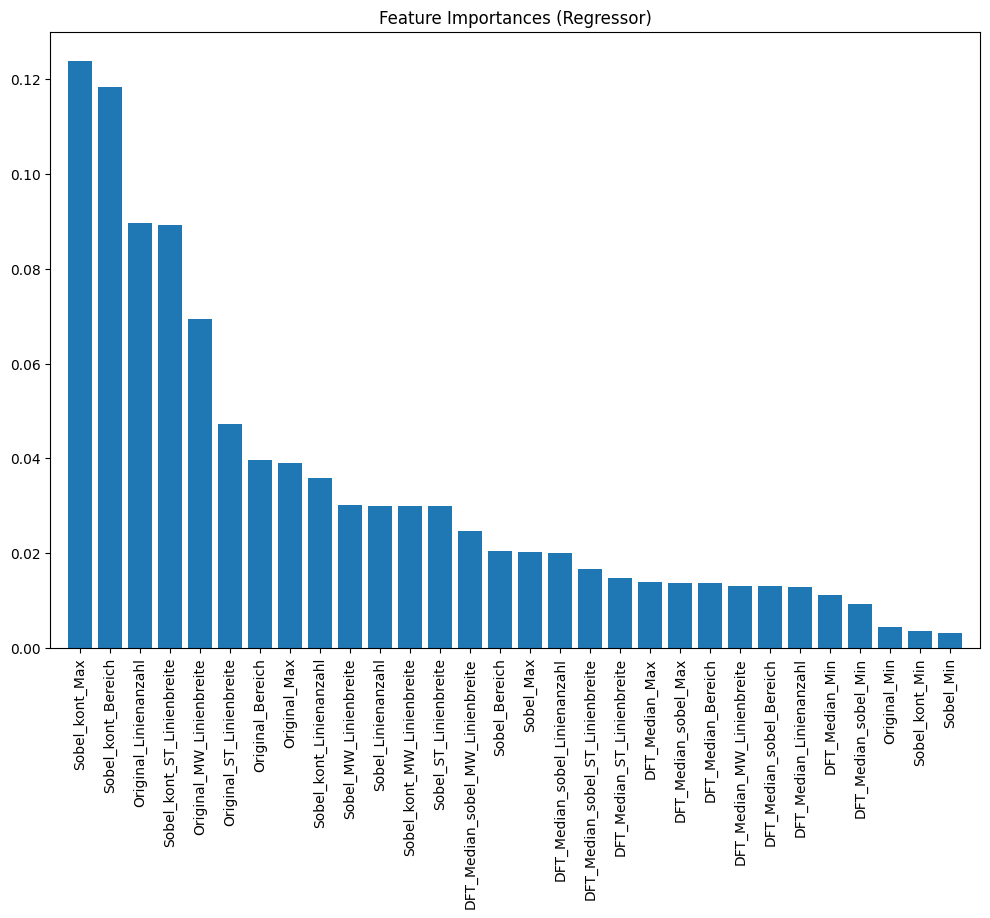

                             Feature  Importance
0                     Sobel_kont_Max    0.123846
1                 Sobel_kont_Bereich    0.118312
2              Original_Linienanzahl    0.089597
3         Sobel_kont_ST_Linienbreite    0.089250
4           Original_MW_Linienbreite    0.069411
5           Original_ST_Linienbreite    0.047152
6                   Original_Bereich    0.039583
7                       Original_Max    0.039000
8            Sobel_kont_Linienanzahl    0.035921
9              Sobel_MW_Linienbreite    0.030135
10                Sobel_Linienanzahl    0.030030
11        Sobel_kont_MW_Linienbreite    0.029929
12             Sobel_ST_Linienbreite    0.029824
13  DFT_Median_sobel_MW_Linienbreite    0.024589
14                     Sobel_Bereich    0.020423
15                         Sobel_Max    0.020281
16     DFT_Median_sobel_Linienanzahl    0.019913
17  DFT_Median_sobel_ST_Linienbreite    0.016735
18        DFT_Median_ST_Linienbreite    0.014632
19                  

<Figure size 640x480 with 0 Axes>

In [8]:
# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Names of the features
feature1 = dataset.columns.get_loc('Original_Linienanzahl')
feature2 = dataset.columns.get_loc('DFT_Median_sobel_Bereich')
feature_names = dataset.columns[feature1:feature2+1]

# Visualization of the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances (Regressor)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
plt.savefig('feature_importances_regressor.png', dpi=300)

# Output of the feature importances
feature_importances = pd.DataFrame({'Feature': feature_names[indices], 'Importance': importances[indices]})
print(feature_importances)

In this function a treshold can be chosen and all the features with lower importances are dropped automatically.

In [9]:
def select_relevant_features(threshold):
    # Filter the features with importance < treshold
    important_features = feature_importances[feature_importances['Importance'] >= threshold]

    # List of features to keep
    features_to_keep = important_features['Feature'].values

    # Selection of the corresponding columns from the original DataFrame
    X_important = dataset[features_to_keep]
    return X_important

threshold = 0.02
X_important = select_relevant_features(threshold)

Complete new train-test split, data augmentation, model training and prediction.

In [10]:
# Convert DataFrame to NumPy array before the train-test split
X_important = X_important.values

# Train-Test-Split
X_train, X_test, y_train, y_test = train_test_split(X_important, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Data augmentation through the addition of noise
noise = np.random.normal(0, 0.01, X_train.shape)  # Noise with mean value 0 and standard deviation 0.01
X_train_augmented = X_train + noise
y_train_augmented = np.copy(y_train)  # Labels stay the same

# Combining original and augmented features
X_train = np.vstack((X_train, X_train_augmented))
y_train = np.concatenate((y_train, y_train_augmented))

# Feature-Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)


# Modeltraining with RandomForestRegressor (after dropping features with low importance)
regressor_dropped = RandomForestRegressor(random_state=42)
regressor_dropped.fit(X_train_scaled, y_train)

# Prediction
y_pred = regressor_dropped.predict(X_test_scaled)
y_val_pred = regressor_dropped.predict(X_val_scaled)

# Validation - Evaluation
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print(f'\nMean Squared Error (Validation): {mse_val}')
print(f'R^2 Score (Validation): {r2_val}\n')

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error (Test): {mse}')
print(f'R^2 Score (Test): {r2}\n')


Mean Squared Error (Validation): 0.0011770862114537449
R^2 Score (Validation): 0.7356406628675525

Mean Squared Error (Test): 0.001264984782608696
R^2 Score (Test): 0.7306481971692904



Now the Error of the prediction from the best model is printed in two graphs. 
The first one shows the predicted and observed values of Ra. Additionally it shows the calculated error between them. 

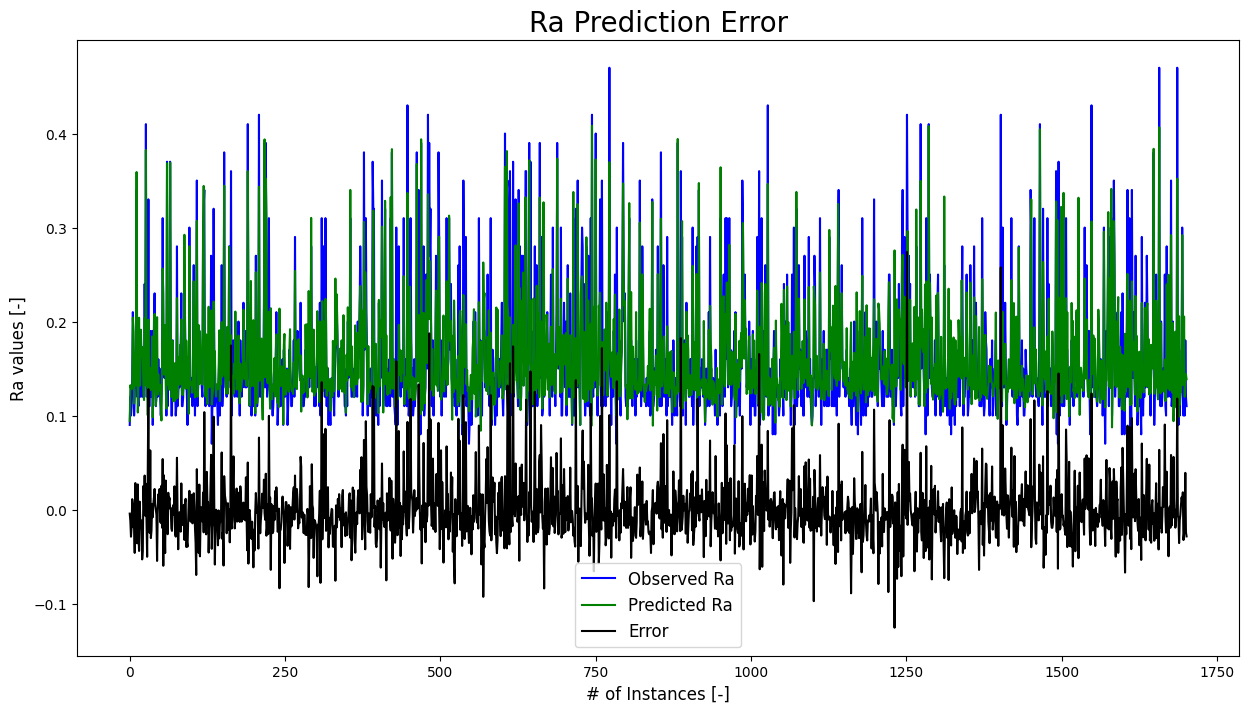

In [11]:
# Error of prediction
error_pred = y_test-y_pred_best

# Plot of the prediction error
plt.figure(figsize=(15, 8))
plt.plot(range(0,len(y_test)), y_test, '-b', label="Observed Ra")
plt.plot(range(0,len(y_pred_best)), y_pred_best, '-g', label="Predicted Ra")
plt.plot(range(0,len(y_pred_best)), error_pred, '-k', label="Error")
plt.title('Ra Prediction Error', fontsize=20)
plt.xlabel('# of Instances [-]', fontsize=12)
plt.ylabel('Ra values [-]', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('regressor_error.png', dpi=300)

The second graph shows the overlapped observed and predicted values for Ra:

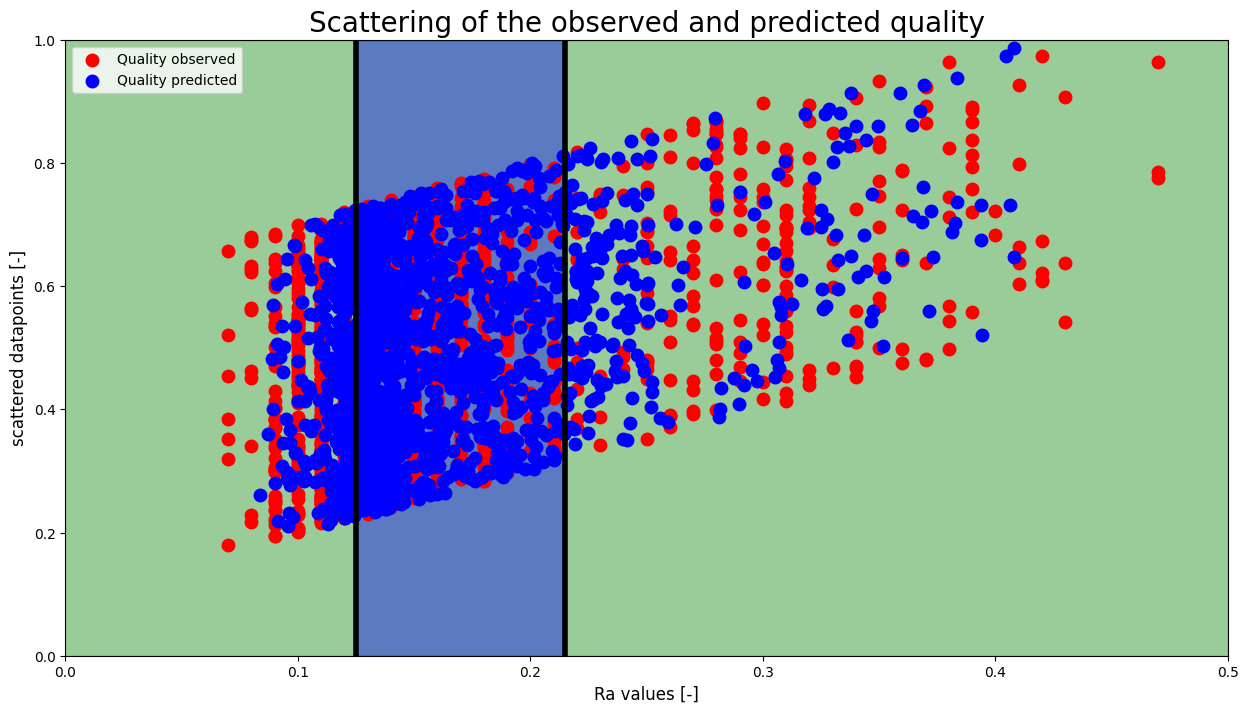

In [12]:
# Specification limits
LOWER_SPECIFICATION_LIMIT = 0.125
UPPER_SPECIFICATION_LIMIT = 0.215

# Plot of the predicted values and the observed values 
plt.figure(figsize=(15,8))
plt.axvline(LOWER_SPECIFICATION_LIMIT,color='black', linewidth=4)
plt.axvline(UPPER_SPECIFICATION_LIMIT,color='black',linewidth=4)
plt.fill_betweenx([0, 1], 0, 0.5, color='green', alpha=0.4) 
plt.fill_betweenx([0, 1], LOWER_SPECIFICATION_LIMIT, UPPER_SPECIFICATION_LIMIT, color='blue', alpha=0.4)
plt.scatter(y_test,y_test + np.random.uniform(0.10,0.6, size=y_test.shape),color='red',linewidth=4, label='Quality observed')
plt.scatter(y_pred_best,y_pred_best + np.random.uniform(0.10,0.6, size=y_pred_best.shape), color='blue',linewidth=4,label='Quality predicted')
plt.title('Scattering of the observed and predicted quality', fontsize=20)
plt.xlabel('Ra values [-]', fontsize=12)
plt.ylabel('scattered datapoints [-]', fontsize=12)
plt.legend()
plt.xlim([0,0.5])
plt.ylim([0,1])
plt.savefig(f'regressor_region_insights.png', dpi=300)

Now the predicted values are used to be saved into a .csv file to do the same analysis as in the classification part.



accuracy_model  : 72.56
recall_model    : 55.76
precision_model : 79.61
confusion matrix: 
[[790 114]
 [353 445]]


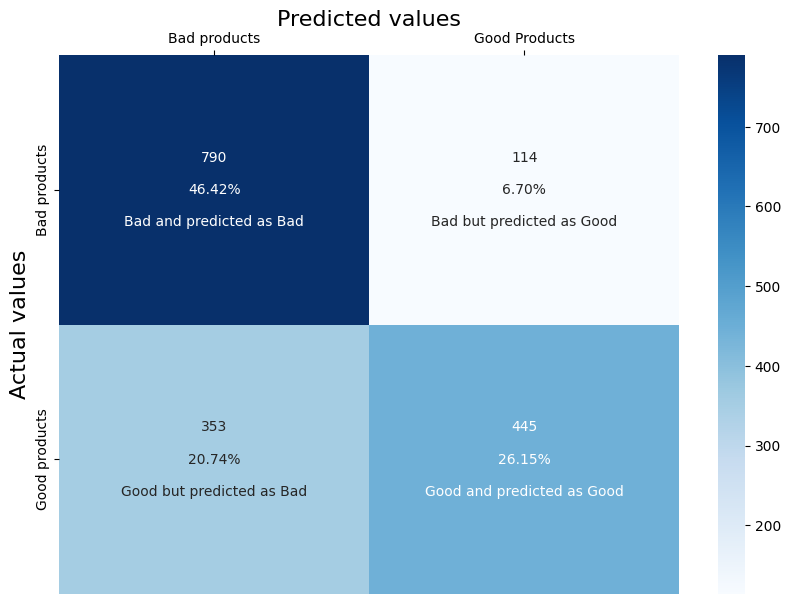

In [14]:
# save the metrics
dic_metric = {'Ra observed': y_test, 'Ra predicted': y_pred_best, 'Error': error_pred}
df = pd.DataFrame(data=dic_metric)

is_observation_in_limits = (df['Ra observed'] > LOWER_SPECIFICATION_LIMIT) & (
        df['Ra observed'] < UPPER_SPECIFICATION_LIMIT)
is_prediction_in_limits = (df['Ra predicted'] > LOWER_SPECIFICATION_LIMIT) & (
        df['Ra predicted'] < UPPER_SPECIFICATION_LIMIT)

df['actual Ra'] = np.where(is_observation_in_limits, 0, 1)
df['predicted Ra'] = np.where(is_prediction_in_limits, 0, 1)

y_true = df['actual Ra'].values
y_pred = df['predicted Ra'].values

#Metrics of  the model
confusion_matrix = confusion_matrix(y_true, y_pred)
accuracy_model = accuracy_score(y_true, y_pred)
recall_model = recall_score(y_true, y_pred.round())
precision_model = precision_score(y_true, y_pred.round())
report = classification_report(y_true, y_pred)

print('\n')
print(f'accuracy_model  : {round(accuracy_model * 100, 2)}')
print(f'recall_model    : {round(recall_model * 100, 2)}')
print(f'precision_model : {round(precision_model * 100, 2)}')
print(f"confusion matrix: \n{confusion_matrix}")

with open('from_reg_metrics_summary.txt', 'w+') as file:
    file.write("################### RESULT OF PREDICTION ###################\n\n")
    file.write(f" accuracy  : {round(accuracy_model * 100, 2)} %\n")
    file.write(f" Recall    : {round(recall_model * 100, 2)} %\n")
    file.write(f" Precision : {round(precision_model * 100, 2)} %\n")
    file.write(f" F1-Score  : {report} %\n")

plt.figure(figsize=(10, 7))
group_names = ["Bad and predicted as Bad", "Bad but predicted as Good", "Good but predicted as Bad",
               "Good and predicted as Good"]
group_counts = ["{0:0.0f}".format(value) for value in confusion_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in confusion_matrix.flatten() / np.sum(confusion_matrix)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts, group_percentages, group_names)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix, annot=labels, xticklabels=['Bad products', 'Good Products'],
            yticklabels=['Bad products', 'Good products'], fmt="", cmap='Blues')
plt.xlabel('Predicted values', fontsize=16)
plt.ylabel('Actual values', fontsize=16)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.savefig(f'from_reg_conf_matrix.png', dpi=300)